In [1]:
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn
import tensorflow

from collections import Counter
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

plt.figure(figsize=(30,10))

seaborn.set(style="ticks")

<Figure size 2160x720 with 0 Axes>

In [2]:
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pd.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [3]:
dataframe = dataframe[dataframe["environment"] == "marsberg"]

In [4]:
def preprocess(dataframe):
    features = []
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        mfcc = librosa.feature.mfcc(y=audio, n_mfcc=24, sr=sample_rate)
        features.append(np.mean(mfcc.T, axis=0))
        
    dataframe["features"] = features
    
    return dataframe

In [5]:
dataframe = preprocess(dataframe)

71it [01:14,  1.04s/it]


In [6]:
x = np.array(dataframe["features"].tolist())
y = np.array(dataframe["label"].tolist())

label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, x_val.shape)

(51, 24) (11, 24) (9, 24)


In [7]:
model = Sequential()
model.add(Dense(400,input_shape=(24,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(800))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

2022-09-19 15:58:29.978908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               10000     
                                                                 
 activation (Activation)     (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 800)               320800    
                                                                 
 activation_1 (Activation)   (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               3

In [8]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['acc'],
    steps_per_execution=100
)

In [11]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=51,
    validation_data=(x_val, y_val),
    shuffle=True
)

Epoch 1/100
1/1 [==============================] - 0s 59ms/step - loss: 1.7680 - acc: 0.3529 - val_loss: 1.6106 - val_acc: 0.2222
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 2.3203 - acc: 0.1961 - val_loss: 1.6082 - val_acc: 0.2222
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 2.3166 - acc: 0.4314 - val_loss: 1.6103 - val_acc: 0.2222
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 2.2974 - acc: 0.2745 - val_loss: 1.6008 - val_acc: 0.2222
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: 2.0446 - acc: 0.2353 - val_loss: 1.6102 - val_acc: 0.2222
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 2.1626 - acc: 0.2353 - val_loss: 1.6103 - val_acc: 0.2222
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 1.8196 - acc: 0.2941 - val_loss: 1.6025 - val_acc: 0.2222
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 1.9001 - acc: 0.21

In [12]:
test_accuracy=model.evaluate(x_test, y_test, verbose=0)
print(test_accuracy[1])

0.5454545617103577


1/1 [==============================] - 0s 201ms/step


<AxesSubplot:>

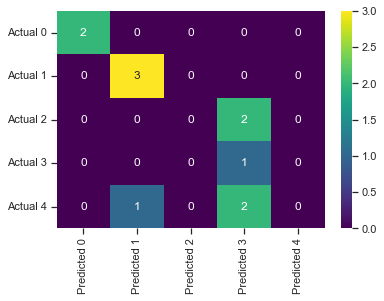

In [13]:
y_true, y_pred = np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1)

def confusion_matrix_table(y_true, y_pred):
    labels = unique_labels(y_test)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    table = pd.DataFrame(cm, columns=columns, index=index)
    return table

def confusion_matrix_plot(y_true, y_pred):
    table = confusion_matrix_table(y_true, y_pred)
    plot = seaborn.heatmap(table, annot=True, fmt="d", cmap="viridis")
    plt.yticks(rotation=0) 
    return plot

confusion_matrix_plot(y_true, y_pred)